# Peak Read Counts

**Created**: 15 November 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("Rtsne")) {
    install.packages("Rtsne")
}

Loading required namespace: patchwork

Loading required namespace: Rtsne



In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(patchwork)
library(Rtsne)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
frip.immune <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/peak_frips.tsv", header=T)
frip.neutrophil <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/peak_frips.tsv", header=T)

frip <- dplyr::bind_rows(
    frip.immune %>% dplyr::select(Sample=Sample_File, Assigned_Reads, Total_Reads, FRiP),
    frip.neutrophil %>% dplyr::select(Sample=Sample_File, Assigned_Reads, Total_Reads, FRiP)
)

In [4]:
head(frip)

,Sample,Assigned_Reads,Total_Reads,FRiP
,<chr>,<int>,<int>,<dbl>
1,Calderon-1003-CD8pos_T-Treatment_1,14208091,38792272,0.3662609
2,Calderon-1003-Naive_CD8_T-Control,7655480,37469207,0.2043139
3,Calderon-1003-Follicular_T_Helper-Control,13366497,36120737,0.3700505
4,Calderon-1001-Regulatory_T-Control,36503275,119947948,0.3043260
5,Calderon-1003-Mem_B-Control,10911199,42371528,0.2575125
6,Calderon-1002-Gamma_delta_T-Treatment_1,15784573,67931514,0.2323601


In [5]:
frip.macs2.immune <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/macs2_peak_frips.tsv", header=T)
frip.macs2.neutrophil <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/macs2_peak_frips.tsv", header=T)

frip.macs2 <- dplyr::bind_rows(
    frip.macs2.immune %>% dplyr::select(Sample=Sample_File, Assigned_Reads, Total_Reads, FRiP),
    frip.macs2.neutrophil %>% dplyr::select(Sample=Sample_File, Assigned_Reads, Total_Reads, FRiP)
)

In [6]:
head(frip.macs2)

,Sample,Assigned_Reads,Total_Reads,FRiP
,<chr>,<int>,<int>,<dbl>
1,Calderon-1003-CD8pos_T-Treatment_1,17106981,38792272,0.4409894
2,Calderon-1003-Naive_CD8_T-Control,6096327,37469207,0.1627023
3,Calderon-1003-Follicular_T_Helper-Control,20828904,36120737,0.5766467
4,Calderon-1001-Regulatory_T-Control,71838380,119947948,0.5989130
5,Calderon-1003-Mem_B-Control,11288860,42371528,0.2664256
6,Calderon-1002-Gamma_delta_T-Treatment_1,16711238,67931514,0.2460013


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Cell.Type=Cell_type, Lineage, Stimulated, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    unique()

rownames(sample.info) <- sample.info$Group.ID

In [8]:
head(sample.info)

,Group.ID,Donor,Cell.Type,Lineage,Stimulated,Treatment
,<chr>,<fct>,<fct>,<fct>,<lgl>,<chr>
Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control,Corces-4983,Monocytes,MYELOID,FALSE,Control
Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-6792,Monocytes,MYELOID,FALSE,Control
Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control,Corces-7256,Monocytes,MYELOID,FALSE,Control
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,Calderon-1001,Bulk_B,B,FALSE,Control
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001,Bulk_B,B,TRUE,Treatment_1
Calderon-1001-Mem_B-Control,Calderon-1001-Mem_B-Control,Calderon-1001,Mem_B,B,FALSE,Control


In [9]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

In [10]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
1,Calderon-1001-Memory_Teffs-Control,35.71484
2,Calderon-1001-Myeloid_DCs-Control,24.90297
3,Calderon-1003-CD8pos_T-Treatment_1,24.91672
4,Calderon-1001-Regulatory_T-Control,30.79065
5,Calderon-1003-Effector_memory_CD8pos_T-Treatment_1,31.39529
6,Calderon-1001-Memory_Tregs-Control,35.20552


## Fraction of Reads in Peaks (FRiP)

The FRiP score for a given sample is a measure of quality of the sample. The median FRiP is $\approx 0.228$.

In [11]:
median(frip.macs2$FRiP)

[1] 0.2623417

In [12]:
median(frip$FRiP)

[1] 0.227543

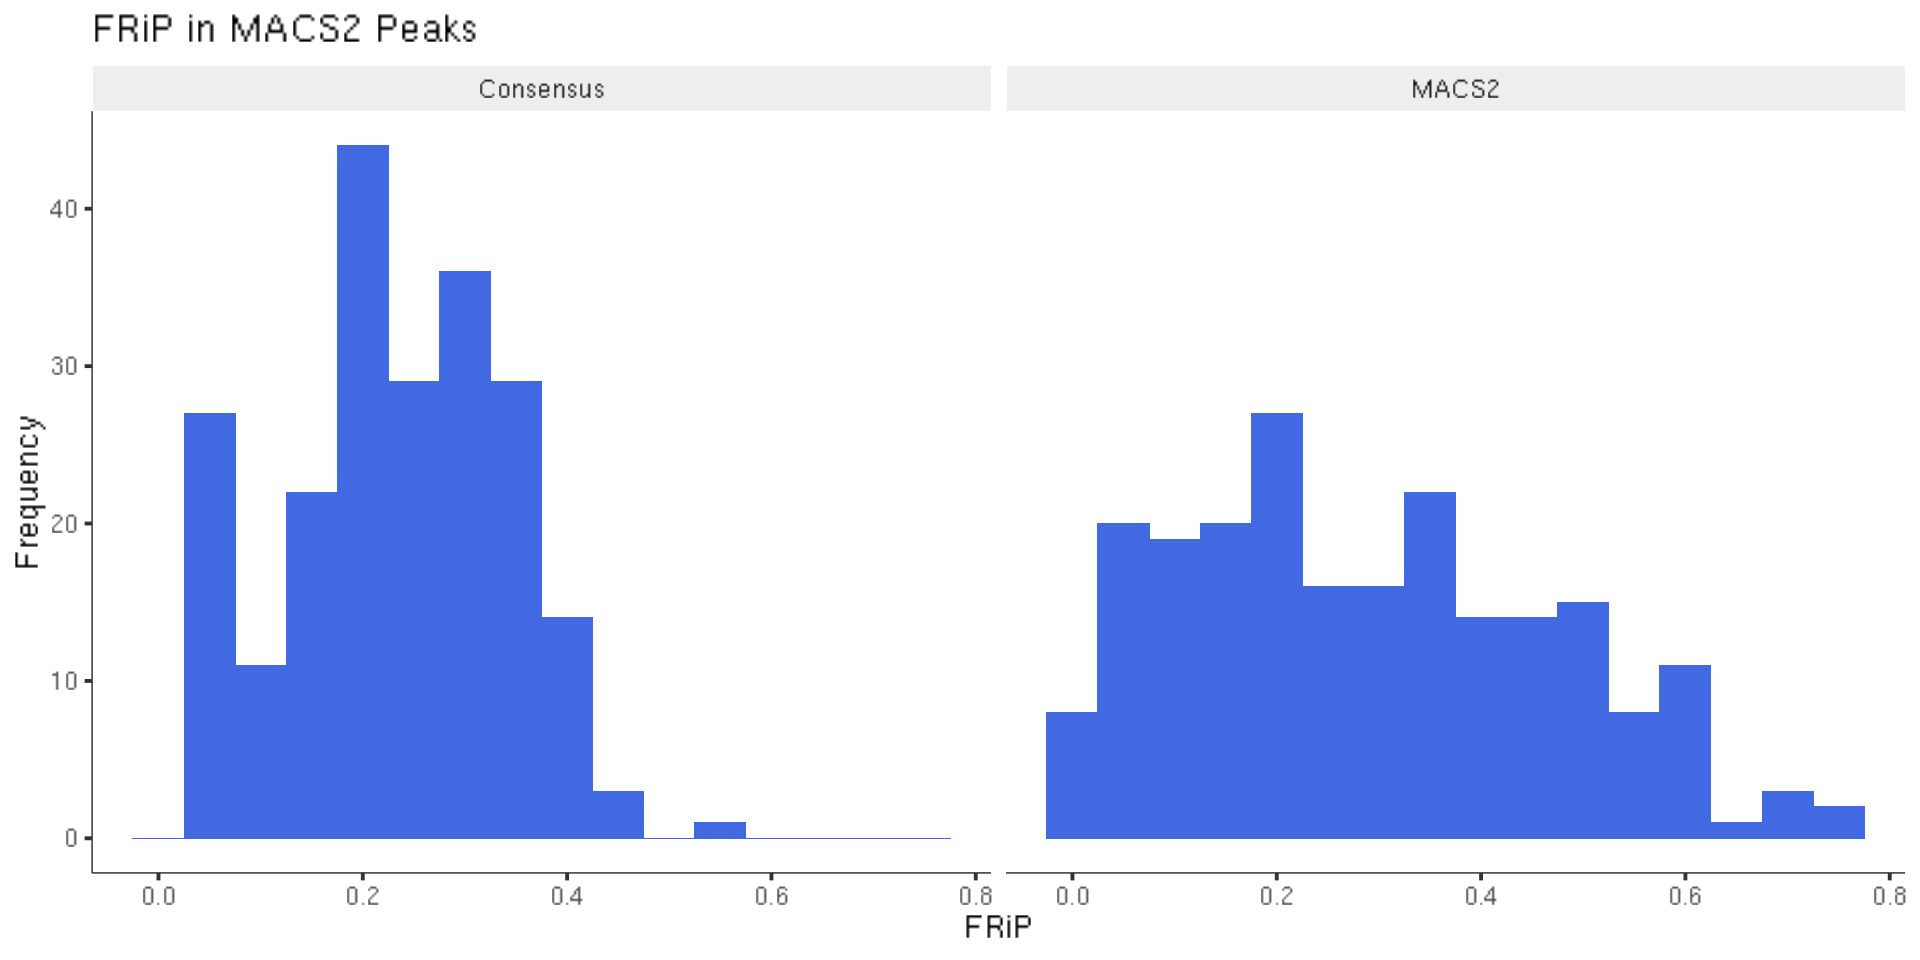

In [32]:
options(repr.plot.width=16, repr.plot.height=8)

dplyr::bind_rows(
    frip %>% dplyr::mutate(Peaks="Consensus"),
    frip.macs2 %>% dplyr::mutate(Peaks="MACS2")
) %>%
    ggplot() +
    geom_histogram(aes(x=FRiP), fill="royalblue", binwidth=0.05) +
    ylab("Frequency") + ggtitle("FRiP in MACS2 Peaks") +
    facet_grid(. ~ Peaks) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/peak_frips.svg", width=16, height=8)

### FRiP by Donor

We flagged donor 1003 previously due to low mapping rates during alignment. Comparing FRiP across donors does not show any quality issues specifically associated with donor 1003.

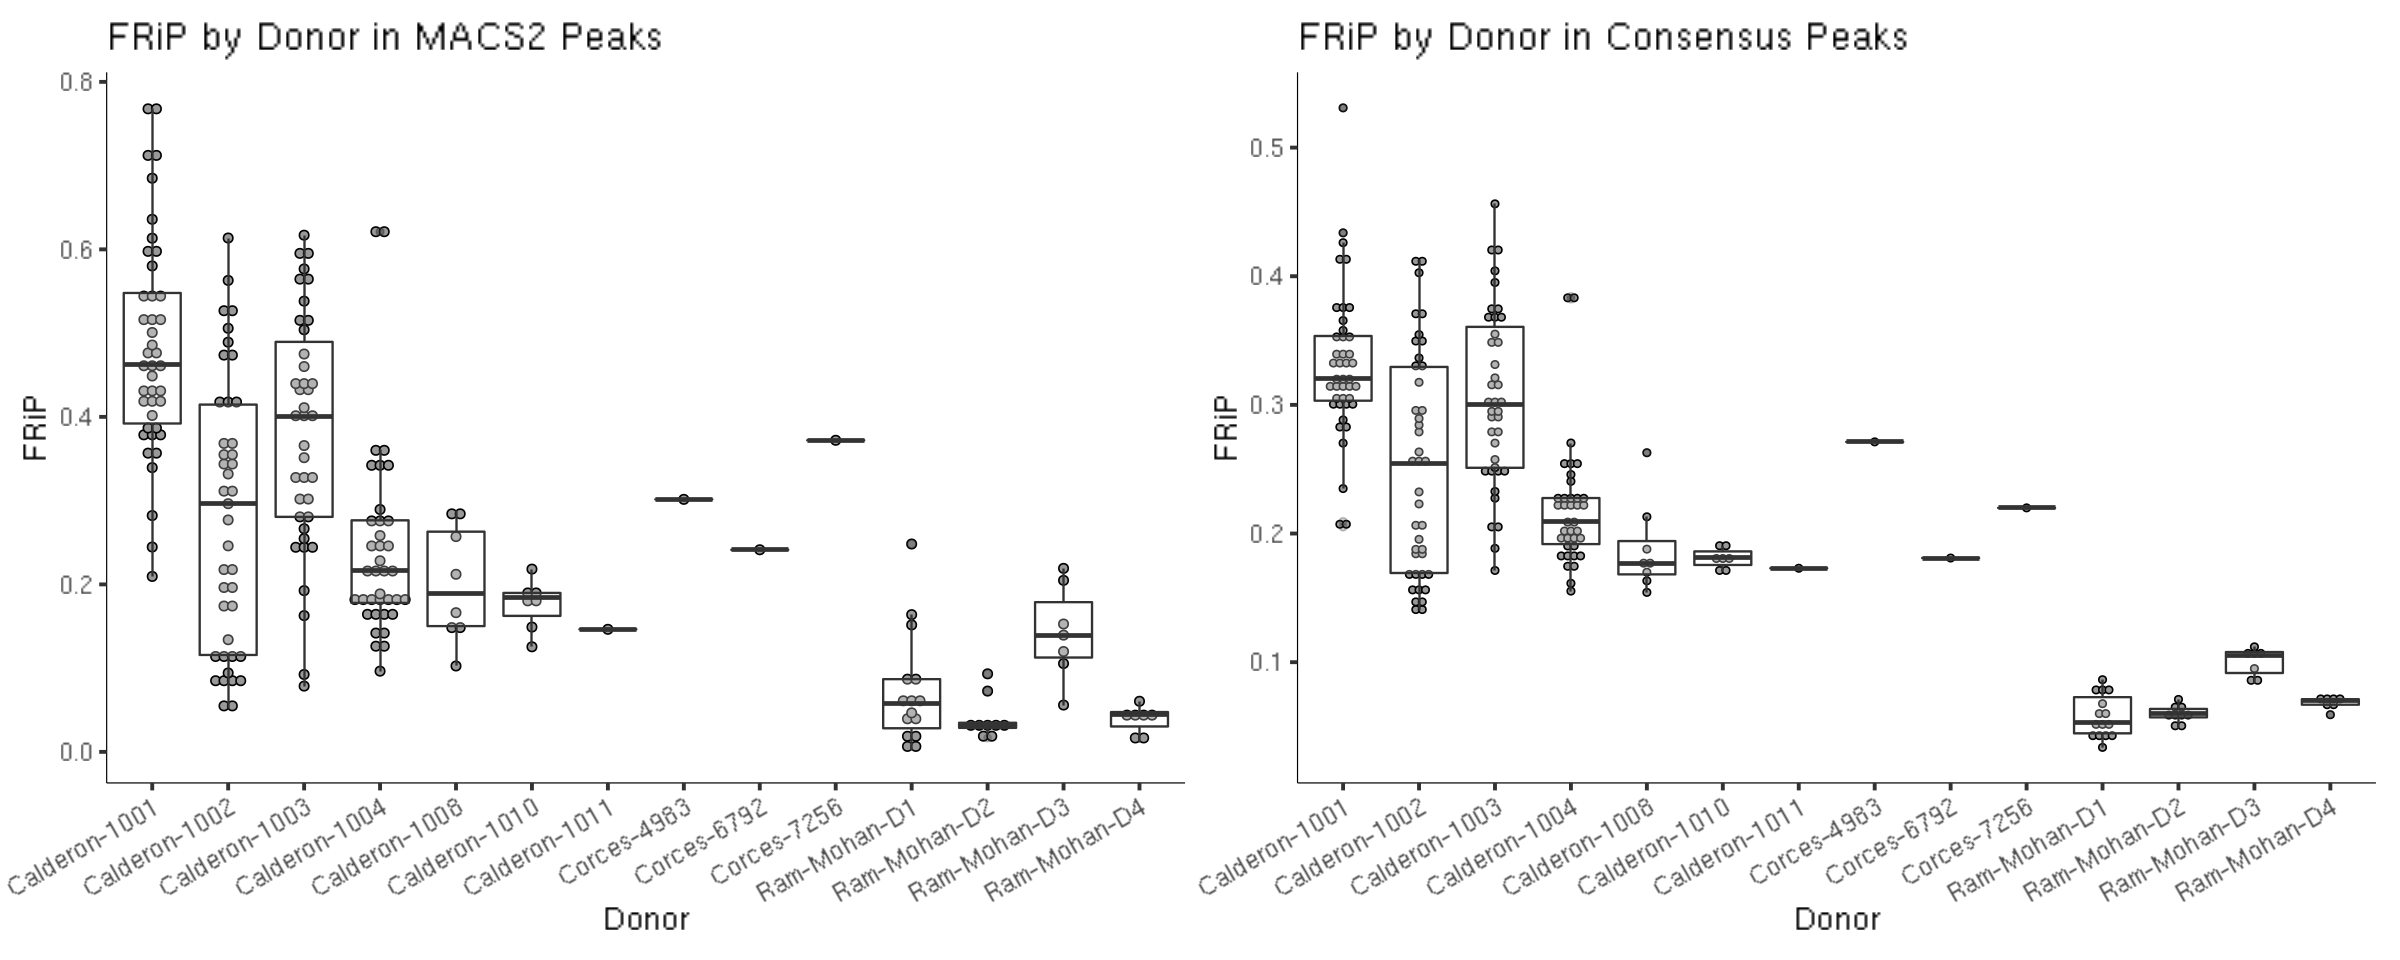

In [33]:
options(repr.plot.width=20, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Donor, y=FRiP)) +
    geom_dotplot(fill="grey60", binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.01) +
    geom_boxplot(alpha=0.25) +
    ggtitle("FRiP by Donor in MACS2 Peaks") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1))

q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Donor, y=FRiP)) +
    geom_dotplot(fill="grey60", binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.005) +
    geom_boxplot(alpha=0.25) +
    ggtitle("FRiP by Donor in Consensus Peaks") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1))

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_by_donor.svg", width=20, height=8)

### FRiP for T Cells

T Cells were stimulated with two conditions:

1. **Treatment 1**: CD3/CD28 Co-stimulation for 24 hours
2. **Treatment 2**: IL-2 for 24 hours

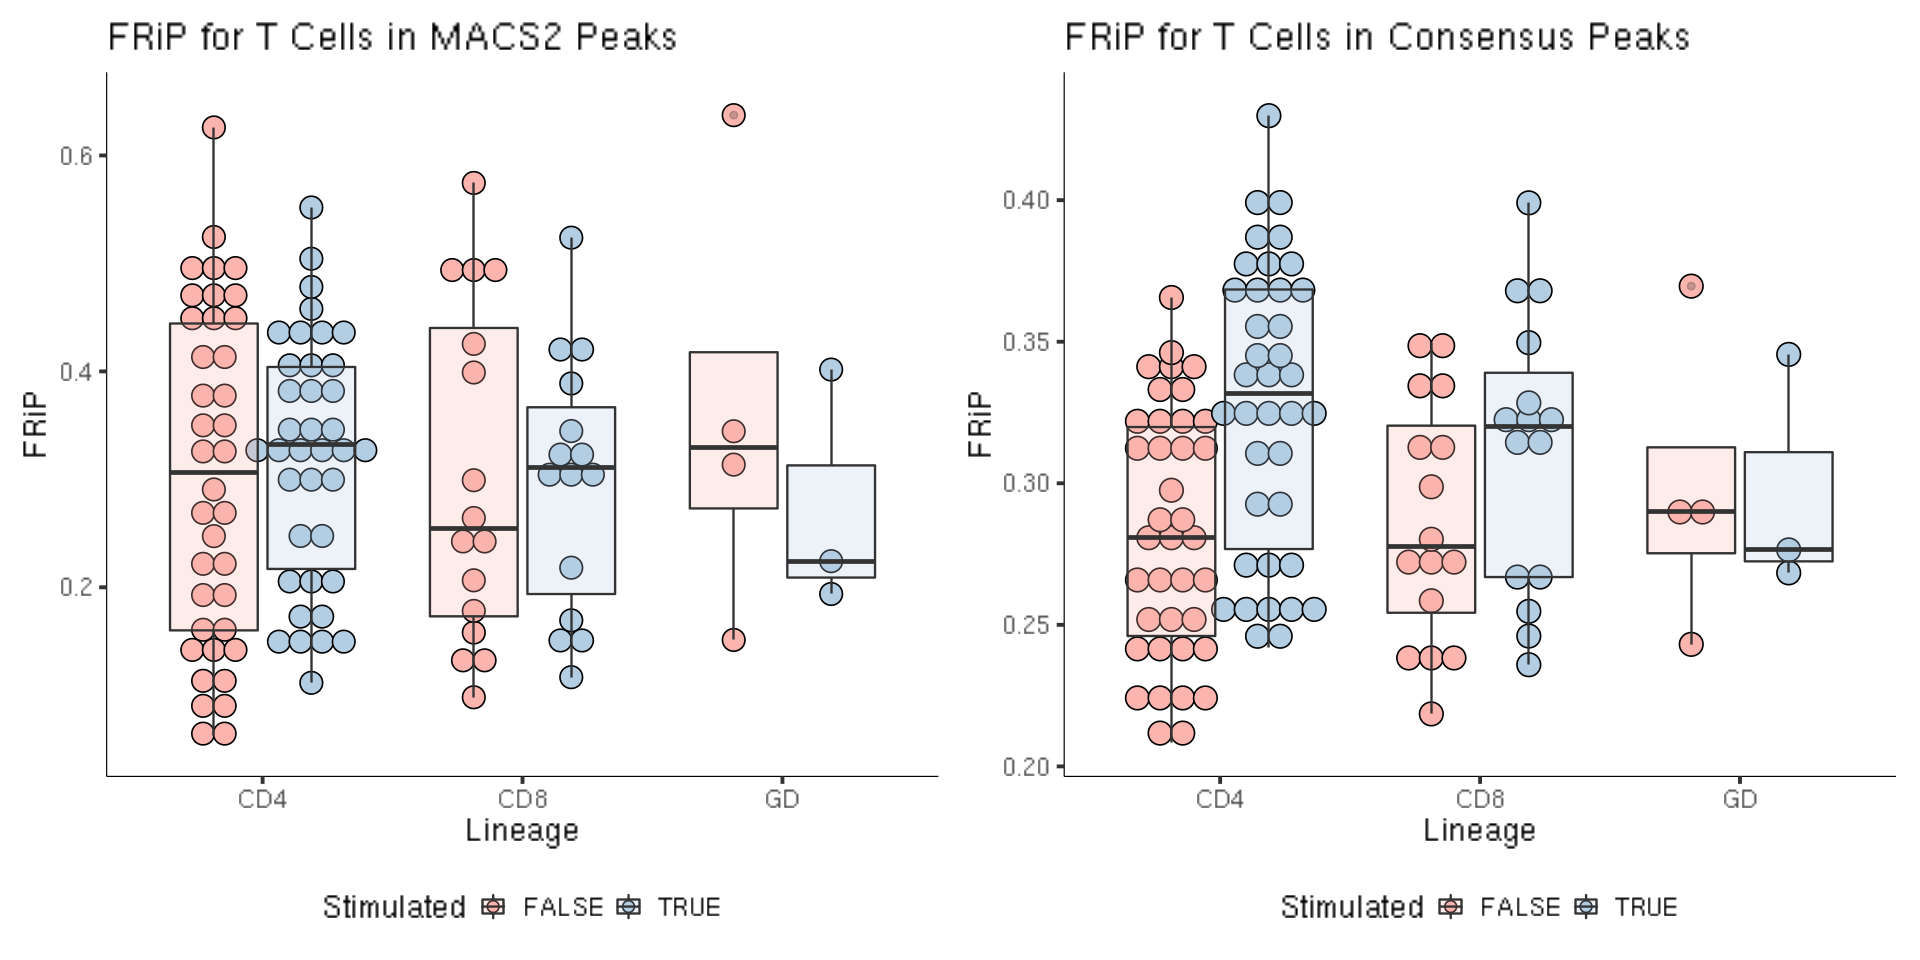

In [34]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="CD4" | Lineage=="CD8" | Lineage=="GD") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for T Cells in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="CD4" | Lineage=="CD8" | Lineage=="GD") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.008) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for T Cells in Consensus Peaks") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_for_t_cells.svg", width=16, height=8)

### FRiP for B Cells

B Cells were stimulated with two conditions:

1. **Treatment 1**: Anti-IgG/IgM Antibodies for 24 hours
2. **Treatment 2**: IL-4 for 24 hours

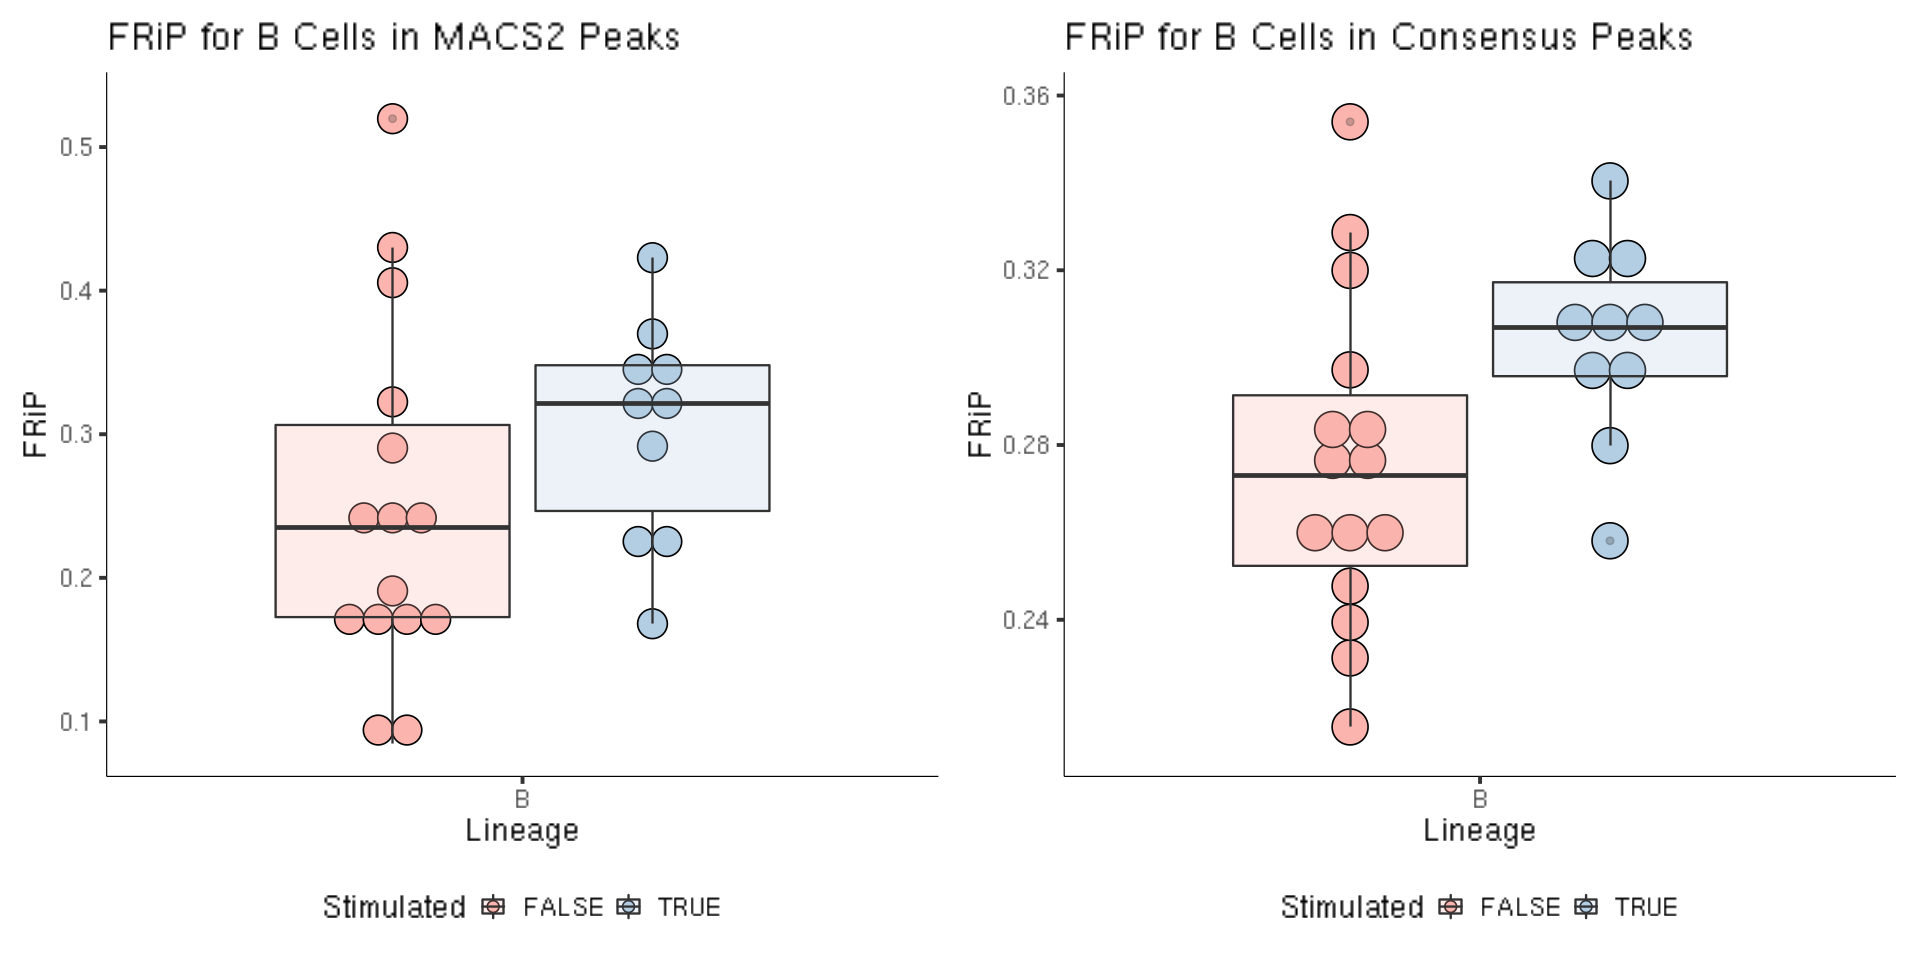

In [36]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="B") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for B Cells in MACS2 Peaks") +
    ggplot_theme


q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="B") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.008) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for B Cells in Consensus Peaks") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_for_b_cells.svg", width=16, height=8)

### FRiP for Monocytes

Monocytes were stimulated with two conditions:

1. **Treatment 1**: LPS (1 $\mu$g/mL) for 24 hours
2. **Treatment 2**: LPS (100 ng/mL) for 6 hours

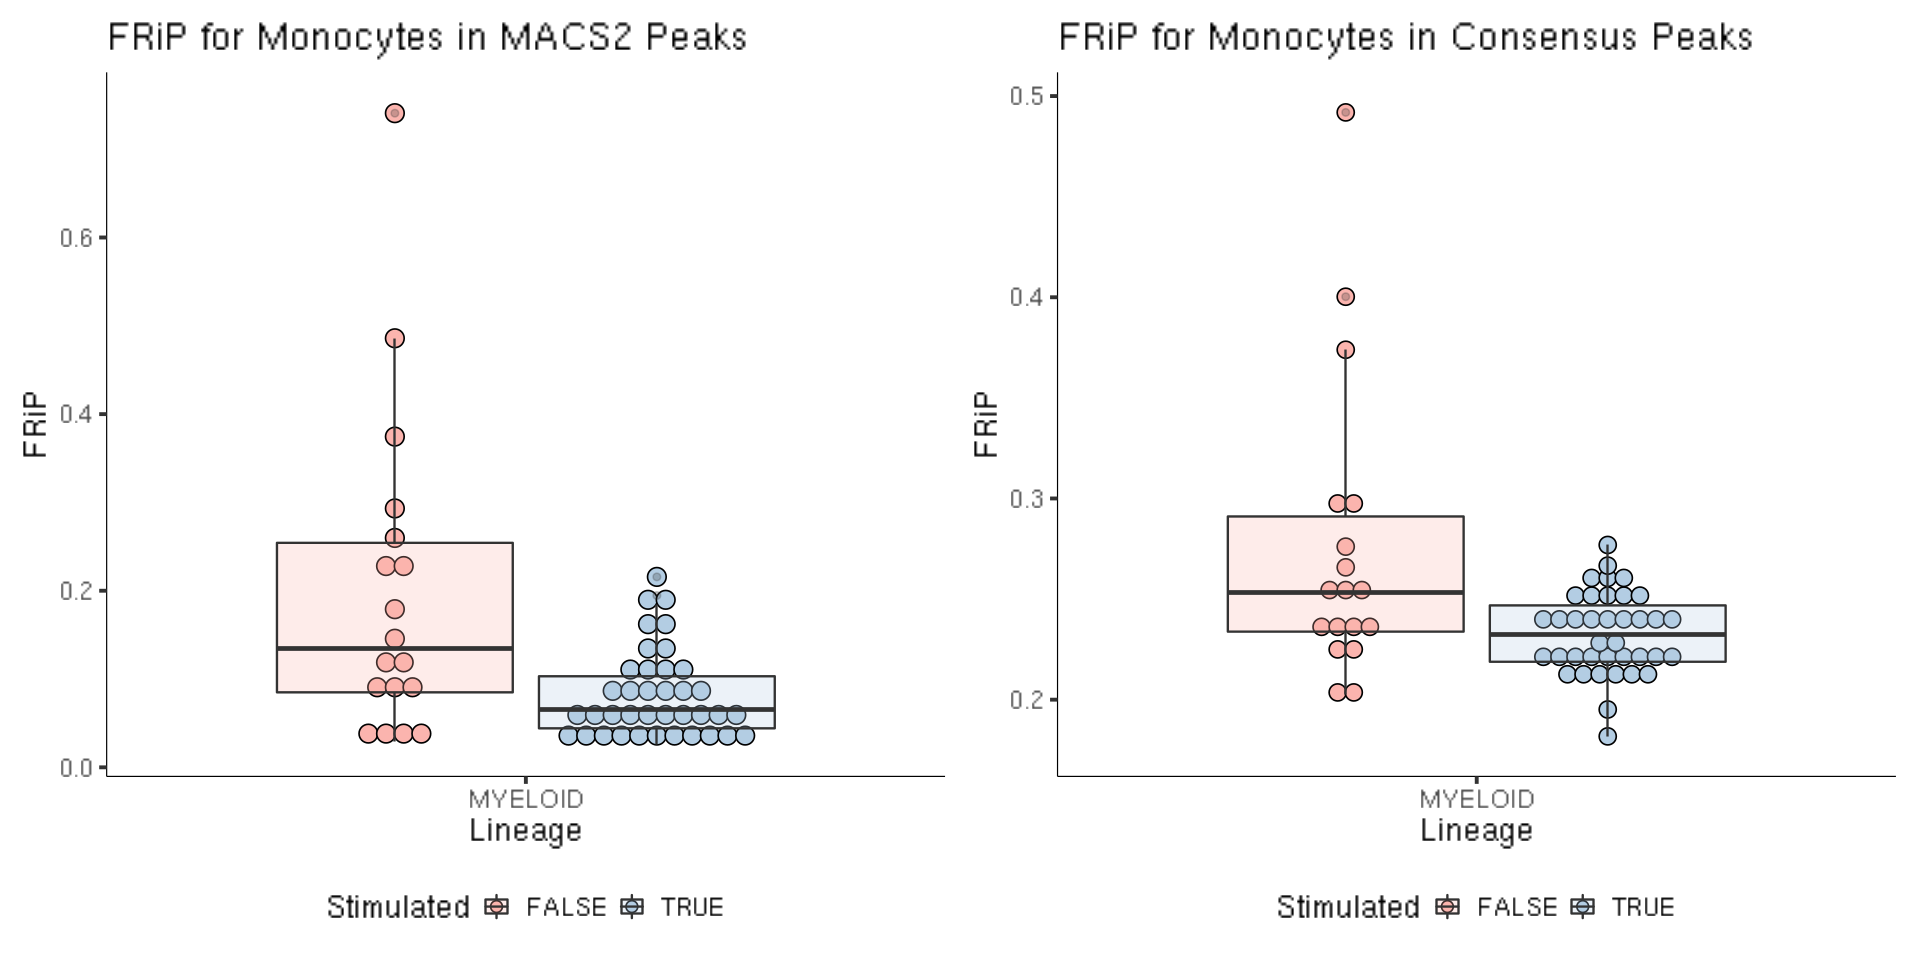

In [40]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="MYELOID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for Monocytes in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="MYELOID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.008) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for Monocytes in Consensus Peaks") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_for_monocytes.svg", width=16, height=8)

### FRiP for NK Cells

NK Cells were stimulated with two conditions:

1. **Treatment 1**: CD2/CD355 beads + IL-2 for 48 hours
2. **Treatment 2**: IL-2 for 24 hours

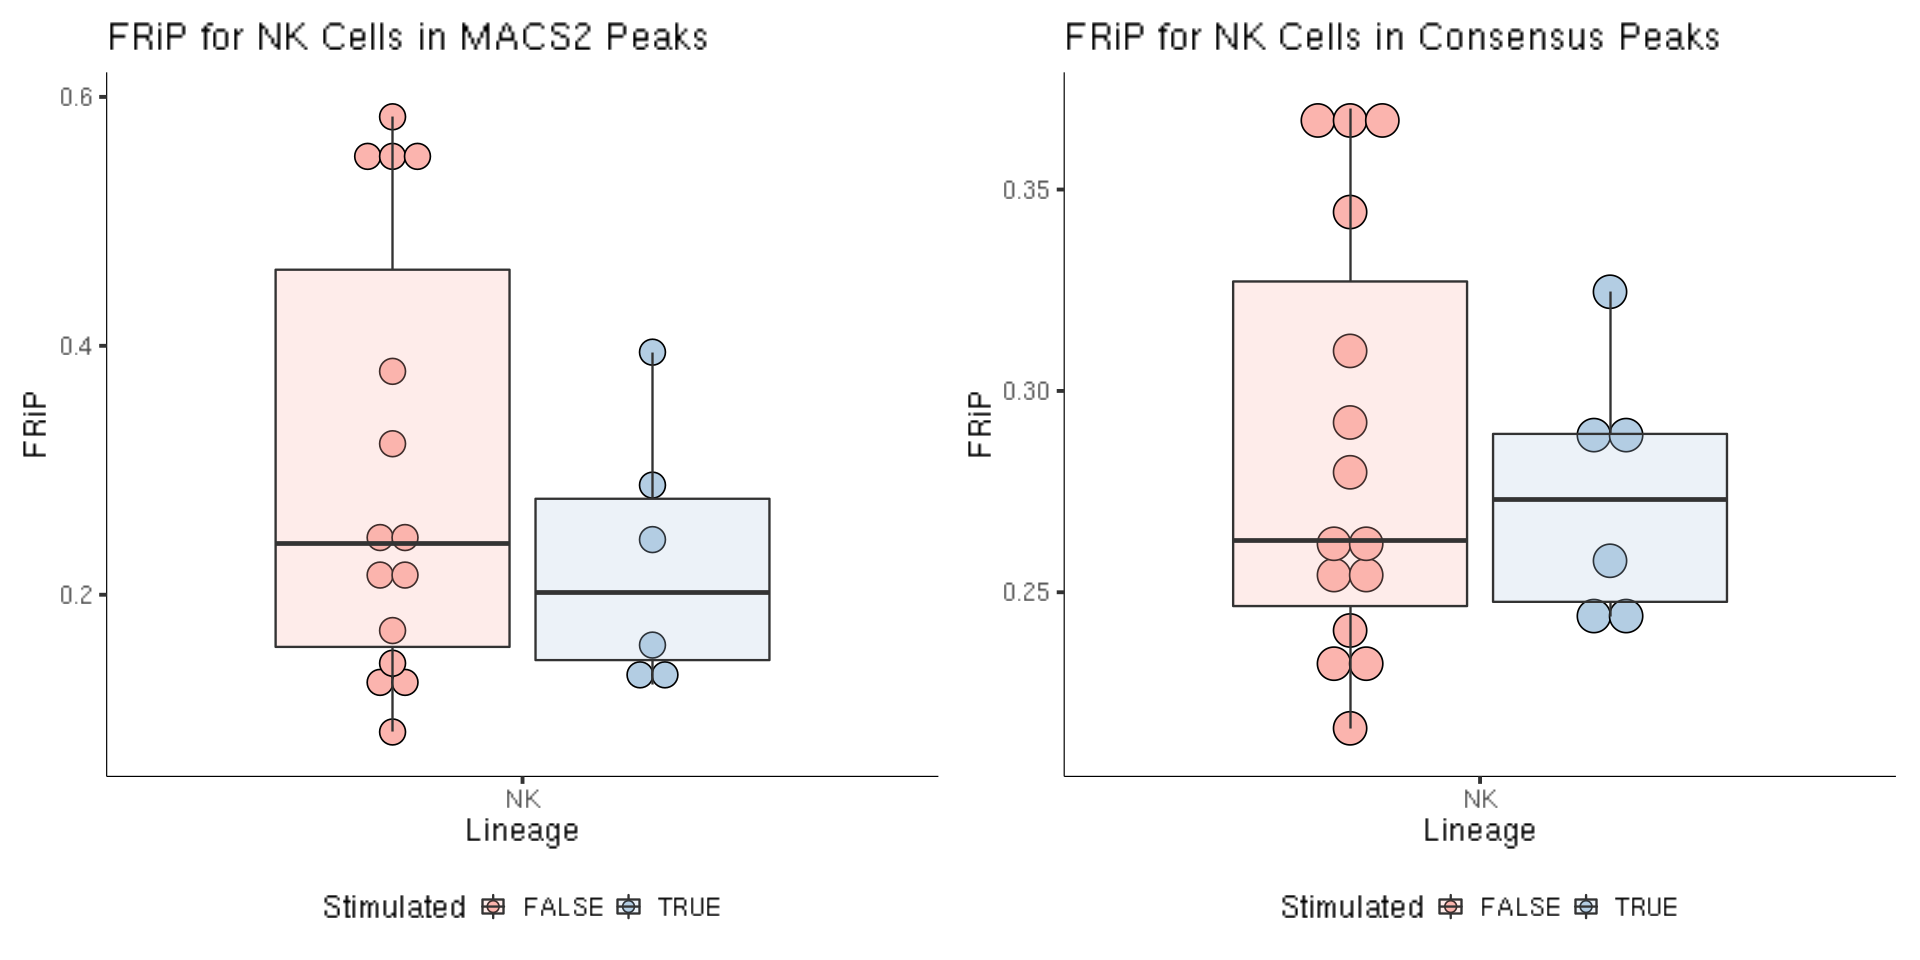

In [42]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="NK") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for NK Cells in MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    dplyr::filter(Lineage=="NK") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Stimulated), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.008) +
    geom_boxplot(aes(fill=Stimulated), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP for NK Cells in Consensus Peaks") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_for_nk_cells.svg", width=16, height=8)

### FRiP by Lineage

The FRiP scores in Myeloid cells are much higher than in the rest. The FRiP scores in NK cells are slightly lower than the rest.

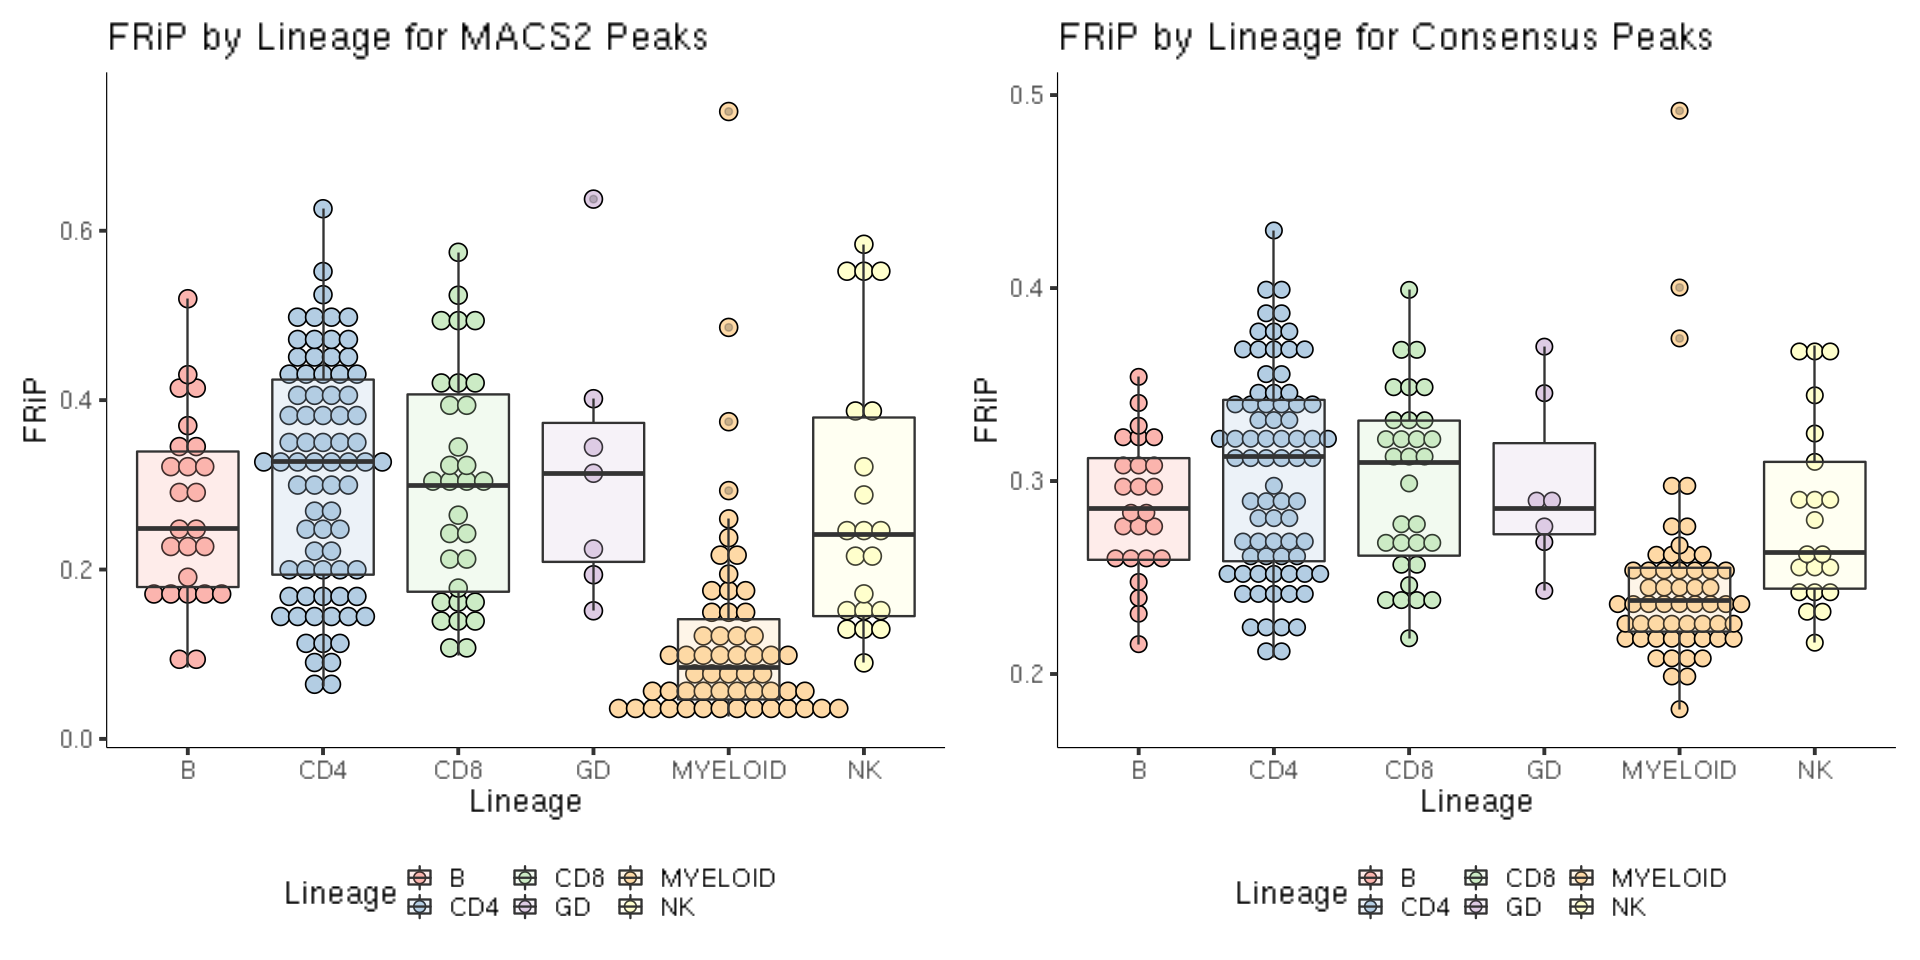

In [44]:
options(repr.plot.width=16, repr.plot.height=8)

p <- merge(frip.macs2, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.02) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Lineage for MACS2 Peaks") +
    ggplot_theme

q <- merge(frip, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Lineage, y=FRiP)) +
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.008) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ggtitle("FRiP by Lineage for Consensus Peaks") +
    ggplot_theme

p + q

ggsave("03_Functional_Interpretation/results/peak_frips_by_lineage.svg", width=16, height=8)

## TSS Enrichment Scores

TSS Enrichment score is calculated as follows:

1. Take the aggregate number of reads mapping to 2kb away from TSSs
2. Take the aggregate number of reads mapping within a 100bp window at TSSs
3. Calculate the fold increase in read coverage at the TSS compared to the 2kb flanking regions

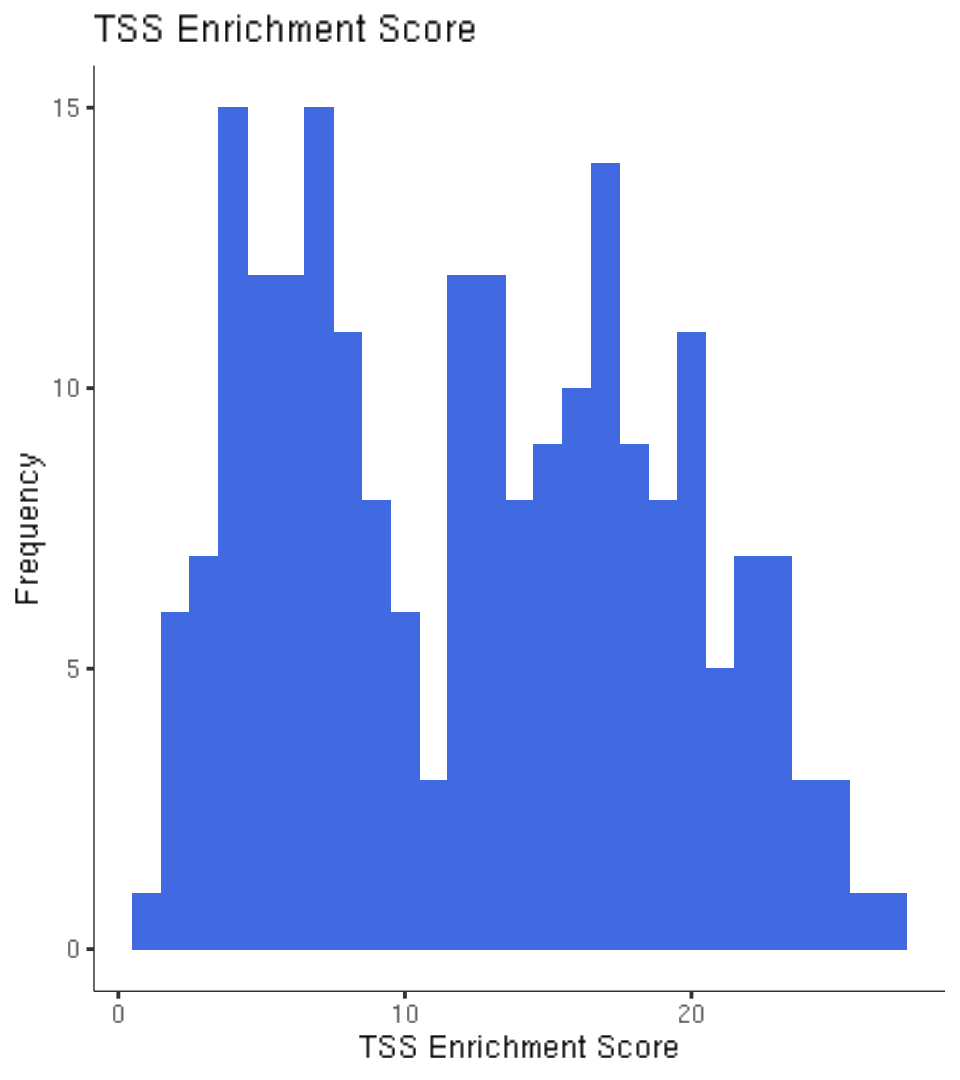

In [50]:
options(repr.plot.width=8, repr.plot.height=9)

ggplot(tss.enrichment) +
    geom_histogram(aes(x=TSS_Enrichment_Score), binwidth=1, fill="royalblue") +
    xlab("TSS Enrichment Score") + ylab("Frequency") +
    ggtitle("TSS Enrichment Score") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores.svg", width=8, height=9)

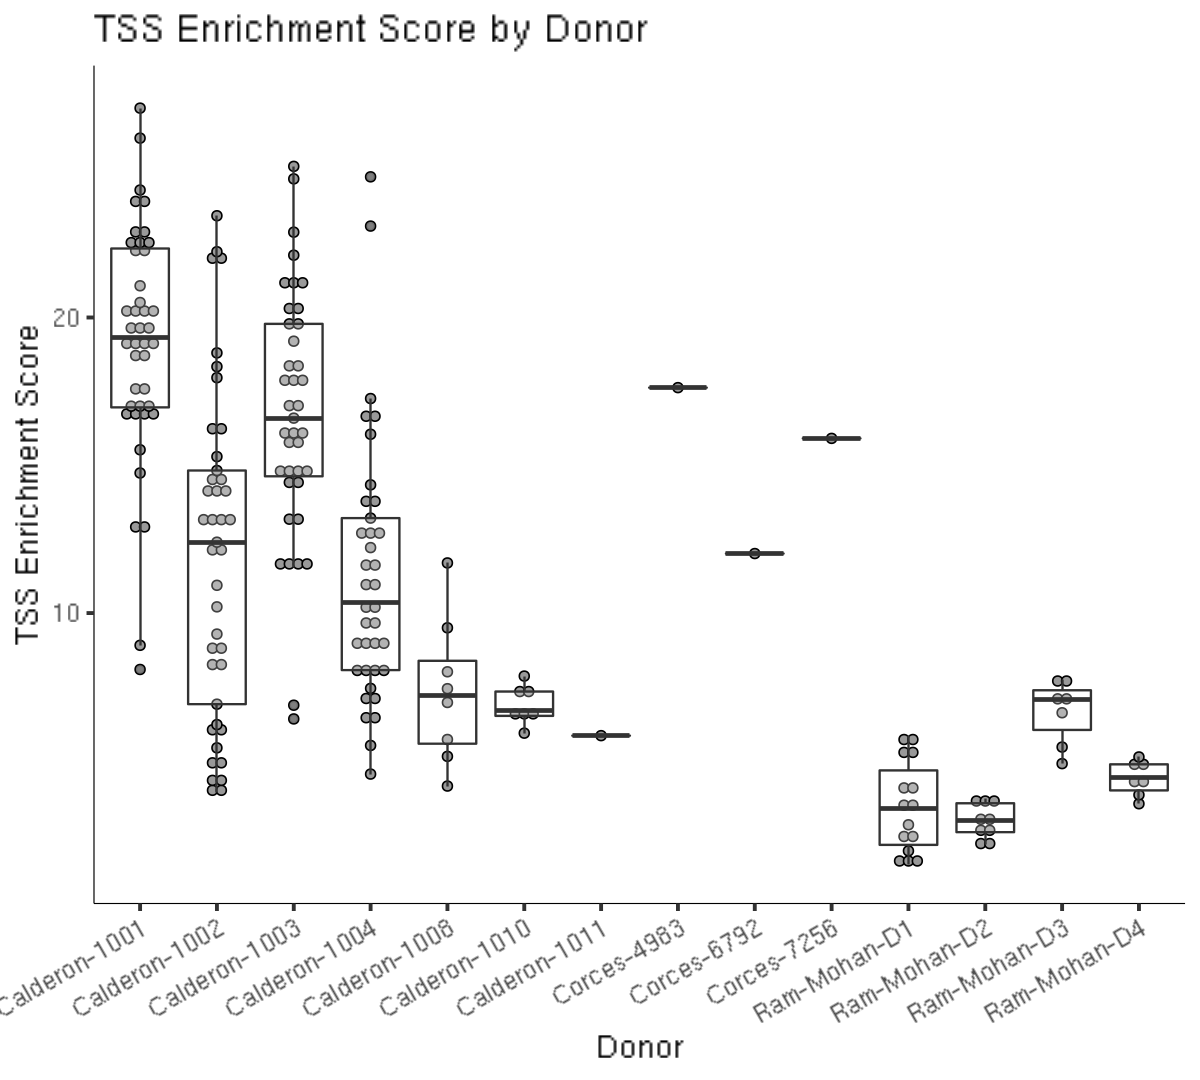

In [60]:
options(repr.plot.width=10, repr.plot.height=9)

merge(tss.enrichment, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Donor, y=TSS_Enrichment_Score)) + 
    geom_dotplot(fill="grey60", binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.3) +
    geom_boxplot(alpha=0.25) +
    ylab("TSS Enrichment Score") +
    ggtitle("TSS Enrichment Score by Donor") +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=30, hjust=1))

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores_by_donor.svg", width=10, height=9)

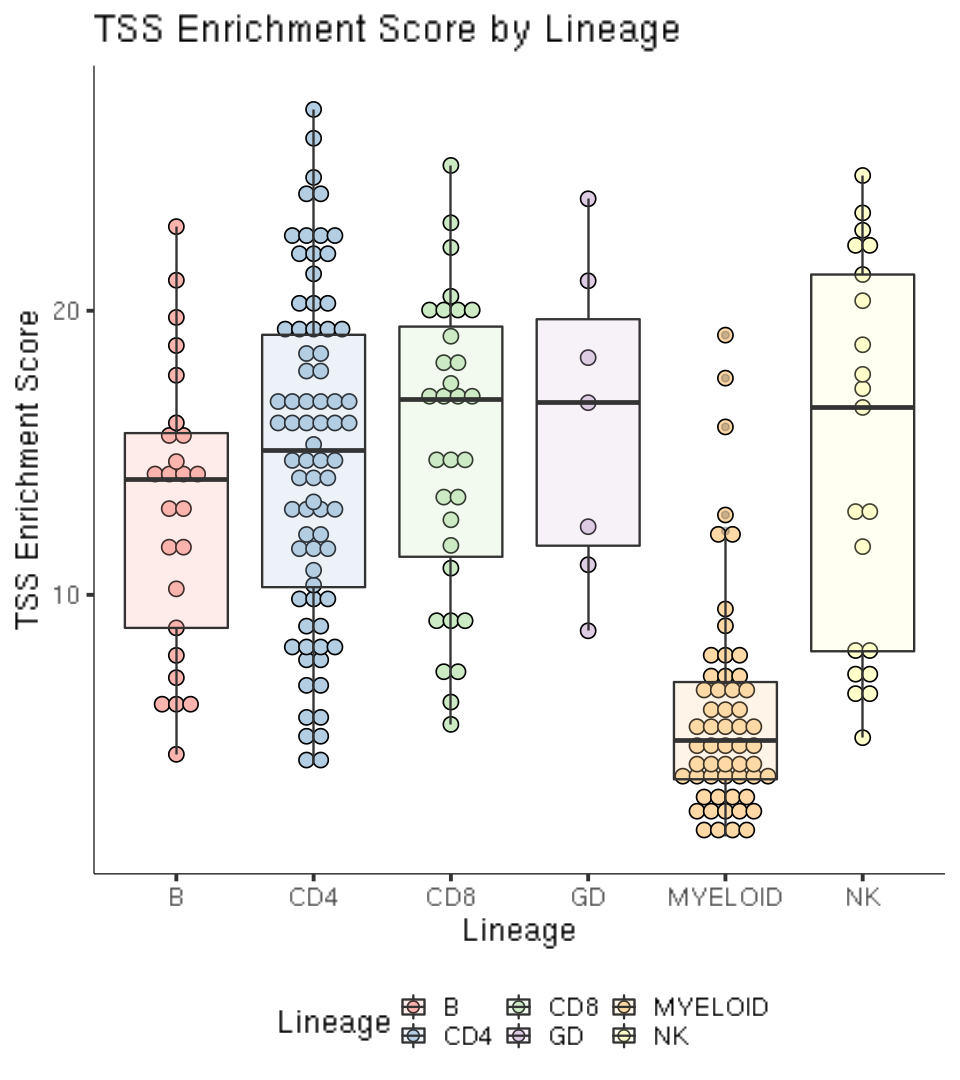

In [63]:
options(repr.plot.width=8, repr.plot.height=9)

merge(tss.enrichment, sample.info, by.x="Sample", by.y="Group.ID") %>%
    ggplot(aes(x=Lineage, y=TSS_Enrichment_Score)) + 
    geom_dotplot(aes(fill=Lineage), binaxis="y", stackdir="center", position=position_dodge(0.75), binwidth=0.5) +
    geom_boxplot(aes(fill=Lineage), alpha=0.25) +
    scale_fill_brewer(palette="Pastel1") +
    ylab("TSS Enrichment Score") +
    ggtitle("TSS Enrichment Score by Lineage") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/tss_enrichment_scores_by_lineage.svg", width=8, height=9)